# Importações

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
from sqlalchemy import create_engine
from statsmodels.tsa.seasonal import STL
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA
from utilsforecast.plotting import plot_series
from datetime import date, timedelta
import calendar

c:\Users\joana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Conexão

In [2]:
df_daily_filled = pd.read_csv('../df_daily_filled.csv', parse_dates=['detected'], dtype='int32')
df_daily_filled = df_daily_filled.set_index('detected')
df_daily_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 943 entries, 2021-08-01 to 2024-02-29
Data columns (total 62 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   direction_2   943 non-null    int32
 1   count_2       943 non-null    int32
 2   direction_3   943 non-null    int32
 3   count_3       943 non-null    int32
 4   direction_4   943 non-null    int32
 5   count_4       943 non-null    int32
 6   direction_5   943 non-null    int32
 7   count_5       943 non-null    int32
 8   direction_6   943 non-null    int32
 9   count_6       943 non-null    int32
 10  direction_7   943 non-null    int32
 11  count_7       943 non-null    int32
 12  direction_8   943 non-null    int32
 13  count_8       943 non-null    int32
 14  direction_9   943 non-null    int32
 15  count_9       943 non-null    int32
 16  direction_10  943 non-null    int32
 17  count_10      943 non-null    int32
 18  direction_11  943 non-null    int32
 19  count_11  

In [3]:
df_loc = pd.read_csv('../all_counter_locations.csv')
df_loc.info()
print()
print(df_daily_filled.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   locationId         31 non-null     int64  
 1   tenantIdentifier   31 non-null     object 
 2   name               31 non-null     object 
 3   cp7                31 non-null     object 
 4   freguesia          31 non-null     object 
 5   directionPositive  0 non-null      float64
 6   directionNegative  0 non-null      float64
 7   latitude           31 non-null     float64
 8   longitude          31 non-null     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.3+ KB

            direction_2  count_2  direction_3  count_3  direction_4  count_4  \
detected                                                                       
2021-08-01          219      327          155      323          138      424   
2021-08-02          144      252          194      381          117

In [4]:
#sem variavel exogena
df_daily_filled = df_daily_filled.resample('D').sum()
df_8 = df_daily_filled.filter(['count_8']).reset_index().assign(unique_id = 8)
df_8 = df_8.filter(['unique_id','detected','count_8'])
df_8.columns = ['unique_id','ds','y']
df_8

,unique_id,ds,y
0,8,2021-08-01,106
1,8,2021-08-02,91
2,8,2021-08-03,115
3,8,2021-08-04,104
4,8,2021-08-05,107
...,...,...,...
938,8,2024-02-25,75
939,8,2024-02-26,112
940,8,2024-02-27,137
941,8,2024-02-28,156


In [5]:
def calcular_pascoa(ano):
    """Calcula a data da Páscoa para um dado ano (algoritmo de Meeus/Jones/Butcher)."""
    a = ano % 19
    b = ano // 100
    c = ano % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19 * a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2 * e + 2 * i - h - k) % 7
    m = (a + 11 * h + 22 * l) // 451
    mes = (h + l - 7 * m + 114) // 31
    dia = ((h + l - 7 * m + 114) % 31) + 1
    return date(ano, mes, dia)

#feriados 
def calcular_feriados_portugal(anos, incluir_lisboa=False):
    feriados = []

    for ano in anos:
        # Feriados
        feriados += [
            date(ano, 1, 1),   # Ano Novo
            date(ano, 4, 25),  # Dia da Liberdade
            date(ano, 5, 1),   # Dia do Trabalhador
            date(ano, 6, 10),  # Dia de Portugal
            date(ano, 8, 15),  # Assunção de Nossa Senhora
            date(ano, 10, 5),  # Implantação da República
            date(ano, 11, 1),  # Dia de Todos os Santos
            date(ano, 12, 1),  # Restauração da Independência
            date(ano, 12, 8),  # Imaculada Conceição
            date(ano, 12, 25), # Natal
            date(ano, 6, 13),  # Santo António
        ]

        # Feriados Domingo de Páscoa
        pascoa = calcular_pascoa(ano)
        feriados += [
            pascoa - timedelta(days=47), # Carnaval
            pascoa - timedelta(days=2),  # Sexta-feira Santa
            pascoa + timedelta(days=1),  # Segunda-feira de Páscoa 
            pascoa + timedelta(days=60), # Corpo de Deus
        ]

    return set(feriados)


In [6]:
anos = df_daily_filled.index.year.unique()
feriados = calcular_feriados_portugal(anos, incluir_lisboa=True)

df_daily_filled['holiday'] = df_daily_filled.index.date
df_daily_filled['holiday'] = df_daily_filled['holiday'].apply(
    lambda x: 1 if x in feriados else 0
)


In [7]:
#fim de semana
df_daily_filled['weekend'] = df_daily_filled.index.weekday.isin([5, 6]).astype(int)
df_daily_filled['exog'] = ((df_daily_filled['holiday'] == 1) | (df_daily_filled['weekend'] == 1)).astype(int)


In [8]:
#com variavel exogena 
df_8_1 = df_daily_filled[['count_8', 'exog']].reset_index().assign(unique_id=8)
df_8_1.columns = ['ds', 'y', 'X', 'unique_id']
df_8_1 = df_8_1[['unique_id', 'ds', 'y', 'X']].query('ds < "2022-08-01"')
df_8_1

,unique_id,ds,y,X
0,8,2021-08-01,106,1
1,8,2021-08-02,91,0
2,8,2021-08-03,115,0
3,8,2021-08-04,104,0
4,8,2021-08-05,107,0
...,...,...,...,...
360,8,2022-07-27,131,0
361,8,2022-07-28,115,0
362,8,2022-07-29,99,0
363,8,2022-07-30,75,1


# MSTL forecast

In [9]:
#model = AutoARIMA(season_length=7)
model = MSTL(season_length=[7], trend_forecaster=AutoARIMA())

sf = StatsForecast(
    models=[model],
    freq='D',
    n_jobs=-1
)

sf.fit(df_8_1)

# Criar o DataFrame de previsão para o próximo dia
future_dates = pd.date_range(start='2024-03-01', periods=1, freq='D')
future_exog = pd.DataFrame({
    'ds': future_dates,
    'X': [0]  
})
future_exog['unique_id'] = 8  

# Realizar a previsão
levels=[99.7]
fcst = sf.forecast(df=df_8_1, X_df=future_exog, h=1, level=levels, fitted=True)

# Exibir as previsões
print(fcst)


   unique_id         ds        MSTL  MSTL-lo-99.7  MSTL-hi-99.7
0          8 2022-08-01  118.129478     49.413067    186.845886


In [10]:
# models = [MSTL(season_length = [7])]
# sf = StatsForecast(
#     models=models, 
#     freq='D',
#     n_jobs=-1,
# )

# horizon = 7
# levels = [99] 

# fcst = sf.forecast(df=df_8_1, h=7, level=[99], fitted=True)
# fcst.head()

In [11]:
insample_forecasts = sf.forecast_fitted_values()
insample_forecasts.head()


,unique_id,ds,y,MSTL,MSTL-lo-99.7,MSTL-hi-99.7
0,8,2021-08-01,106.0,97.394295,28.677883,166.110703
1,8,2021-08-02,91.0,98.473061,29.756651,167.189468
2,8,2021-08-03,115.0,95.154320,26.437908,163.870728
3,8,2021-08-04,104.0,108.334389,39.617977,177.050797
4,8,2021-08-05,107.0,99.840744,31.124329,168.557159


In [12]:
# anomalies = insample_forecasts[~insample_forecasts['y'].between(insample_forecasts['MSTL-lo-99'], insample_forecasts['MSTL-hi-99'])]
# anomalies
anomalies = insample_forecasts[
    ~insample_forecasts['y'].between(
        insample_forecasts.iloc[:,4],
        insample_forecasts.iloc[:,5]
    )
]

anomalies

,unique_id,ds,y,MSTL,MSTL-lo-99.7,MSTL-hi-99.7
146,8,2021-12-25,276.0,91.666786,22.950373,160.383194
147,8,2021-12-26,389.0,228.984833,160.268417,297.701233
148,8,2021-12-27,50.0,174.463547,105.747131,243.179962


In [13]:
plot_series(forecasts_df=insample_forecasts, level=levels, plot_anomalies=True, engine='plotly')

# Função dinamica

In [14]:
def fill_zeros(df_daily_filled, max_weeks_back=5):
    df_filled = df_daily_filled.copy()
    for col in df_daily_filled.columns:
        if col.startswith('count_'):
            zero_dates = df_daily_filled[df_daily_filled[col] == 0].index
            for datetime in zero_dates:
                for weeks_back in range(1, max_weeks_back + 1):
                    prev_week = datetime - pd.Timedelta(weeks=weeks_back)
                    if prev_week in df_daily_filled.index:
                        prev_value = df_daily_filled.loc[prev_week, col]
                        if prev_value != 0:
                            df_filled.loc[datetime, col] = prev_value
                            break
    return df_filled


In [15]:
def aplica_algoritmo(df_daily_filled, contador_id, exog_col='exog',
                     start_date='2021-08-01', end_date='2022-08-01',
                     season_length=[7], n_jobs=-1, datas_corrigidas_previamente=None):
    
    if contador_id is None:
        raise ValueError("É necessário especificar o 'contador_id'.")
    
    if contador_id not in df_daily_filled.columns:
        raise ValueError(f"Contador {contador_id} não encontrado no DataFrame.")
    
    if exog_col not in df_daily_filled.columns:
        raise ValueError(f"Coluna exógena {exog_col} não encontrada no DataFrame.")
    
    if datas_corrigidas_previamente is None:
        datas_corrigidas_previamente = set()
    
    # 1. Filtrar dados históricos até à data limite
    df_hist = df_daily_filled.loc[start_date:end_date].copy()
    df_hist[contador_id] = df_hist[contador_id].astype(float)

    # 2. Substituir dias com zéros 
    df_hist_corr = fill_zeros(df_hist)
    

    # 3. Preparar dados para StatsForecast
    unique_id = contador_id
    df_model = df_hist_corr[[contador_id, exog_col]].reset_index().assign(unique_id=unique_id)
    df_model.columns = ['ds', 'y', 'X', 'unique_id']
    df_model = df_model[['unique_id', 'ds', 'y', 'X']]

    # 4. Ajustar o modelo
    model = MSTL(season_length=season_length, trend_forecaster=AutoARIMA())
    sf = StatsForecast(models=[model], freq='D', n_jobs=n_jobs)
    sf.fit(df_model)
    
    
    # 5. Previsão (1 dia à frente apenas, para completar fitting)
    future_dates = pd.date_range(start=df_model['ds'].max() + pd.Timedelta(days=1), periods=1, freq='D')
    future_exog_values = [1 if d.date() in feriados else 0 for d in future_dates]

    future_exog = pd.DataFrame({
        'ds': future_dates,
        'X': future_exog_values,
        'unique_id': [contador_id] * len(future_dates)      
    })

    levels=[99.7]
    sf.forecast(df=df_model, X_df=future_exog, h=1, level=levels, fitted=True)

    # 6. Obter previsões in-sample e identificar outliers
    insample_fcst = sf.forecast_fitted_values()
    insample_fcst.columns = ['unique_id', 'ds', 'y', 'fitted', 'lo_99_7', 'hi_99_7']

    anomalies = insample_fcst[
        ~insample_fcst['y'].between(insample_fcst['lo_99_7'], insample_fcst['hi_99_7'])
    ].copy()

    novas_datas_corrigidas = set()

    # 7. Corrigir anomalias
    for _, row in anomalies.iterrows():
        dia = row['ds']
        
        if dia in datas_corrigidas_previamente or dia in novas_datas_corrigidas:
            continue

        y = row['y']
        hi = row['hi_99_7']
        lo = row['lo_99_7']
        historico = df_hist_corr.loc[df_hist_corr.index < dia, contador_id]

        if historico.empty:
            continue

        max_hist = historico.max()

        if y > hi:
            novo_valor = min(hi, max_hist)
        elif y < lo:
            novo_valor = lo
        else:
            continue

        df_hist_corr.loc[dia, contador_id] = novo_valor
        novas_datas_corrigidas.add(dia)


    # 9. Retornar histórico corrigido, anomalias, datas corrigidas e componente semanal
    return df_hist_corr, anomalies, novas_datas_corrigidas



In [16]:
#para um periodo de 2 semanas no maximo: 

# def get_one_more_week(df_daily_filled, df_hist, weeks_added, max_weeks=2):
#     if weeks_added >= max_weeks:
#         return df_hist, weeks_added, False

#     last_date = df_hist.index.max()
#     next_week_start = last_date + pd.Timedelta(days=1)
#     next_week_end = next_week_start + pd.Timedelta(days=6)
#     df_next_week = df_daily_filled.loc[next_week_start:next_week_end]

#     if df_next_week.empty:
#         return df_hist, weeks_added, False

#     df_hist_updated = pd.concat([df_hist, df_next_week])
#     return df_hist_updated, weeks_added + 1, True


# para todos os dados: 

# def get_one_more_week(df_daily_filled, df_hist, weeks_added):
#     last_date = df_hist.index.max()
#     next_week_start = last_date + pd.Timedelta(days=1)
#     next_week_end = next_week_start + pd.Timedelta(days=6)

#     df_next_week = df_daily_filled.loc[next_week_start:next_week_end]

#     if df_next_week.empty:
#         return df_hist, weeks_added, False

#     df_hist_updated = pd.concat([df_hist, df_next_week])
#     return df_hist_updated, weeks_added + 1, True



# Rolling windows (janela deslizante), avança de uma semana e elimina uma semana do inicio
def get_one_more_week_rolling(df_daily_filled, df_hist, weeks_added, janela_semanas=52):
    last_date = df_hist.index.max()
    next_week_start = last_date + pd.Timedelta(days=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    df_next_week = df_daily_filled.loc[next_week_start:next_week_end]

    if df_next_week.empty:
        return df_hist, weeks_added, False

    # Concatenar nova semana
    df_hist_updated = pd.concat([df_hist, df_next_week])

    # Manter janela de tamanho fixo (em semanas)
    dias_janela = janela_semanas * 7
    min_date = df_hist_updated.index.max() - pd.Timedelta(days=dias_janela - 1)
    df_hist_updated = df_hist_updated[df_hist_updated.index >= min_date]

    return df_hist_updated, weeks_added + 1, True


In [17]:
# # Dicionários para guardar resultados de cada contador <- para todos os contadores
# resultados_corrigidos_por_contador = {}
# anomalias_por_contador = {}

resultados_corrigidos = [] # <- quando for para todos os contadores esta linha e as 2 proximas não são necessarias
todas_anomalias = []
datas_corrigidas_global = set()

contador_id = 'count_8' # <- quando for para todos os contadores tem de ser eliminada
exog_col = 'exog'
start_date = '2021-08-01'
end_date_inicial = '2022-07-31'
#max_semanas = 2
semanas_adicionadas = 0 #quando for para todos os contadores tem de ser eliminada

# for contador_id in colunas_contadores:  <- par todos os contadores
#     if not contador_id.startswith("count_"):
#         continue  # ignora colunas que não são contadores

#     print(f"\n### PROCESSANDO {contador_id} ###")

#     resultados_corrigidos = []
#     todas_anomalias = []
#     datas_corrigidas_global = set()
#     semanas_adicionadas = 0

    # Aplicar primeira vez
df_hist_atual, anomalies_iniciais, datas_corrigidas = aplica_algoritmo(
    df_daily_filled=df_daily_filled,
    contador_id=contador_id,
    exog_col=exog_col,
    start_date=start_date,
    end_date=end_date_inicial,
    datas_corrigidas_previamente=datas_corrigidas_global
)

    # Atualizar listas
datas_corrigidas_global.update(datas_corrigidas)
resultados_corrigidos.append(df_hist_atual.copy())
todas_anomalias.append(anomalies_iniciais)

    # Loop
while True:    
#while semanas_adicionadas < max_semanas:
    df_hist_atual, semanas_adicionadas, conseguiu_adicionar = get_one_more_week_rolling(
        df_daily_filled=df_daily_filled,
        df_hist=df_hist_atual,
        weeks_added=semanas_adicionadas,
        #max_weeks=max_semanas
        janela_semanas=52  # ou outro valor
    )

    if not conseguiu_adicionar:
        print("Não há mais semanas para adicionar.")
        break

    df_corrigido, novas_anomalias, novas_datas_corrigidas = aplica_algoritmo(
        df_daily_filled=df_hist_atual,
        contador_id=contador_id,
        exog_col=exog_col,
        start_date=start_date,
        end_date=df_hist_atual.index.max().strftime('%Y-%m-%d'),
        datas_corrigidas_previamente=datas_corrigidas_global
    )

    # Filtrar anomalias para ignorar as que já foram corrigidas antes
    novas_anomalias = novas_anomalias[~novas_anomalias['ds'].isin(datas_corrigidas_global)].copy()

    # Atualizar conjunto global das datas corrigidas
    datas_corrigidas_global.update(novas_datas_corrigidas)

    df_hist_atual = df_corrigido.copy()
    resultados_corrigidos.append(df_hist_atual.copy())
    todas_anomalias.append(novas_anomalias)

    print(f"Semana {semanas_adicionadas} processada com {len(novas_anomalias)} novos outliers.")


    # # Guardar resultados <- para todos os contadores
    # resultados_corrigidos_por_contador[contador_id] = resultados_corrigidos
    # anomalias_por_contador[contador_id] = pd.concat(todas_anomalias, ignore_index=True)

Semana 1 processada com 1 novos outliers.
Semana 2 processada com 1 novos outliers.
Semana 3 processada com 0 novos outliers.
Semana 4 processada com 0 novos outliers.
Semana 5 processada com 0 novos outliers.
Semana 6 processada com 0 novos outliers.
Semana 7 processada com 1 novos outliers.
Semana 8 processada com 0 novos outliers.
Semana 9 processada com 0 novos outliers.
Semana 10 processada com 0 novos outliers.
Semana 11 processada com 1 novos outliers.
Semana 12 processada com 1 novos outliers.
Semana 13 processada com 1 novos outliers.
Semana 14 processada com 0 novos outliers.
Semana 15 processada com 0 novos outliers.
Semana 16 processada com 0 novos outliers.
Semana 17 processada com 0 novos outliers.
Semana 18 processada com 0 novos outliers.
Semana 19 processada com 1 novos outliers.
Semana 20 processada com 0 novos outliers.
Semana 21 processada com 0 novos outliers.
Semana 22 processada com 1 novos outliers.
Semana 23 processada com 0 novos outliers.
Semana 24 processada

In [18]:
#Juntar todas as anomalias detetadas 
anomalias_totais = pd.concat(todas_anomalias)
anomalias_totais

# Para todos os contadores
# anomalias_totais = pd.concat(
#     [df.assign(contador=contador_id) for contador_id, df in anomalias_por_contador.items() if not df.empty],
#     ignore_index=True
# )

# if anomalias_totais.empty:
#     print("Nenhuma anomalia encontrada.")
# else:
#     print(anomalias_totais[['ds', 'contador', 'y', 'lo_99_7', 'hi_99_7']])



,unique_id,ds,y,fitted,lo_99_7,hi_99_7
146,count_8,2021-12-25,276.0,91.666785,22.950374,160.383197
147,count_8,2021-12-26,389.0,228.984836,160.268424,297.701248
148,count_8,2021-12-27,50.0,174.463543,105.747131,243.179955
87,count_8,2021-11-04,177.0,109.819141,56.880014,162.758267
357,count_8,2022-08-08,14.0,119.927474,64.477089,175.377859
358,count_8,2022-09-13,233.0,164.812446,108.727536,220.897356
357,count_8,2022-10-10,84.0,142.506784,85.557143,199.456425
359,count_8,2022-10-19,90.0,147.520689,90.363700,204.677677
358,count_8,2022-10-25,281.0,187.569480,128.324823,246.814137
8,count_8,2021-12-21,39.0,98.193451,39.097650,157.289252


In [19]:
df_corrigido_final = pd.concat(resultados_corrigidos)
df_corrigido_final = df_corrigido_final[~df_corrigido_final.index.duplicated(keep='last')]

fig = px.line(
    df_corrigido_final, 
    y=contador_id, 
    title=f"Contagem corrigida – {contador_id}",
    labels={"index": "Data", contador_id: "Contagem"},
)

fig.update_layout(width=1900, height=350)
fig.show()


# Se eu quiser fazer para todos os contadores

# for contador_id, lista_resultados in resultados_corrigidos_por_contador.items():
#     if not lista_resultados:
#         continue  # pular se a lista estiver vazia

#     df_corrigido_final = lista_resultados[-1]  # último resultado corrigido

#     fig = px.line(
#         df_corrigido_final,
#         y=contador_id,
#         title=f"Contagem corrigida - {contador_id}",
#         labels={"index": "Data", contador_id: "Contagem"}
#     )
#     fig.update_layout(width=1300, height=350)
#     fig.show()



# Métodos basicos 

### Seasonality ratio

In [ ]:
# Preparação dos dados 
df = df_corrigido_final.copy() # copia para não modificar o original
df.index = pd.to_datetime(df.index)
serie_count_8 = df['count_8'].copy()

df_semanal = serie_count_8.reset_index() # dataframe só com o contador 8, ano e semana
df_semanal['ano'] = df_semanal['detected'].dt.isocalendar().year # criar a coluna ano 
df_semanal['semana'] = df_semanal['detected'].dt.isocalendar().week # criar a coluna semana

# 1. Cálculo dos índices sazonais 
# Média anual
df_media_anual = df_semanal.groupby('ano')['count_8'].mean().reset_index(name='media_anual')
# Média semanal da contagem para cada ano
df_media_semanal = df_semanal.groupby(['ano', 'semana'])['count_8'].mean().reset_index(name='media_semanal')

# Merge para calcular índice sazonal (%)
df_indices = pd.merge(df_media_semanal, df_media_anual, on='ano')
df_indices['indice_sazonal'] = (df_indices['media_semanal'] / df_indices['media_anual']) * 100

# 2. Índice sazonal agregado (média por semana em todos os anos)
df_agregado = df_semanal.groupby('semana')['count_8'].mean().reset_index(name='media_agg')
media_total = df_semanal['count_8'].mean()
df_agregado['indice_sazonal_agg'] = (df_agregado['media_agg'] / media_total) * 100

#  Seasonality Ratio 
seasonality_ratios = df_indices.groupby('ano')['indice_sazonal'].agg(lambda x: x.max() / 100).reset_index(name='seasonality_ratio')
seasonality_ratio_agg = df_agregado['indice_sazonal_agg'].max() / 100

print("Seasonality Ratio por ano:")
print(seasonality_ratios)
print(f"\nSeasonality Ratio agregado: {seasonality_ratio_agg:.2f}")


Seasonality Ratio por ano:
    ano  seasonality_ratio
0  2021           1.251024
1  2022           1.572099
2  2023           1.473588
3  2024           1.174999

Seasonality Ratio agregado: 1.30


Seasonality ratio indica quanto a semana mais movimentada está acima da média anual. 
No ano de 2021 temos sazonalidade 25% acima da média (não temos o ano completo), quer dizer que a semana mais movimentada tem 25% mais ciclistas que a média anual daquele ano.
No ano de 2022 temos um pico forte, porque se semana de pico teve 57% mais uso que a média anual.
No ano de 2023 temos um pico significativo. 
No ano de 2024 temos sazonalidade 17% acima da média (não temos o ano completo).
Média geral de todos os anos temos sazonalidae 30% acima da média. 
Portanto, 2022 é o ano que teve maior sazonalidade e 2024 é o ano com mais fraca sazonalidade (mas tens de ter em conta que não é um ano completo).
Na média geral dos anos, o padrão sazonal é relevante, com semanas que ficam em média 30% acima da média anual. 

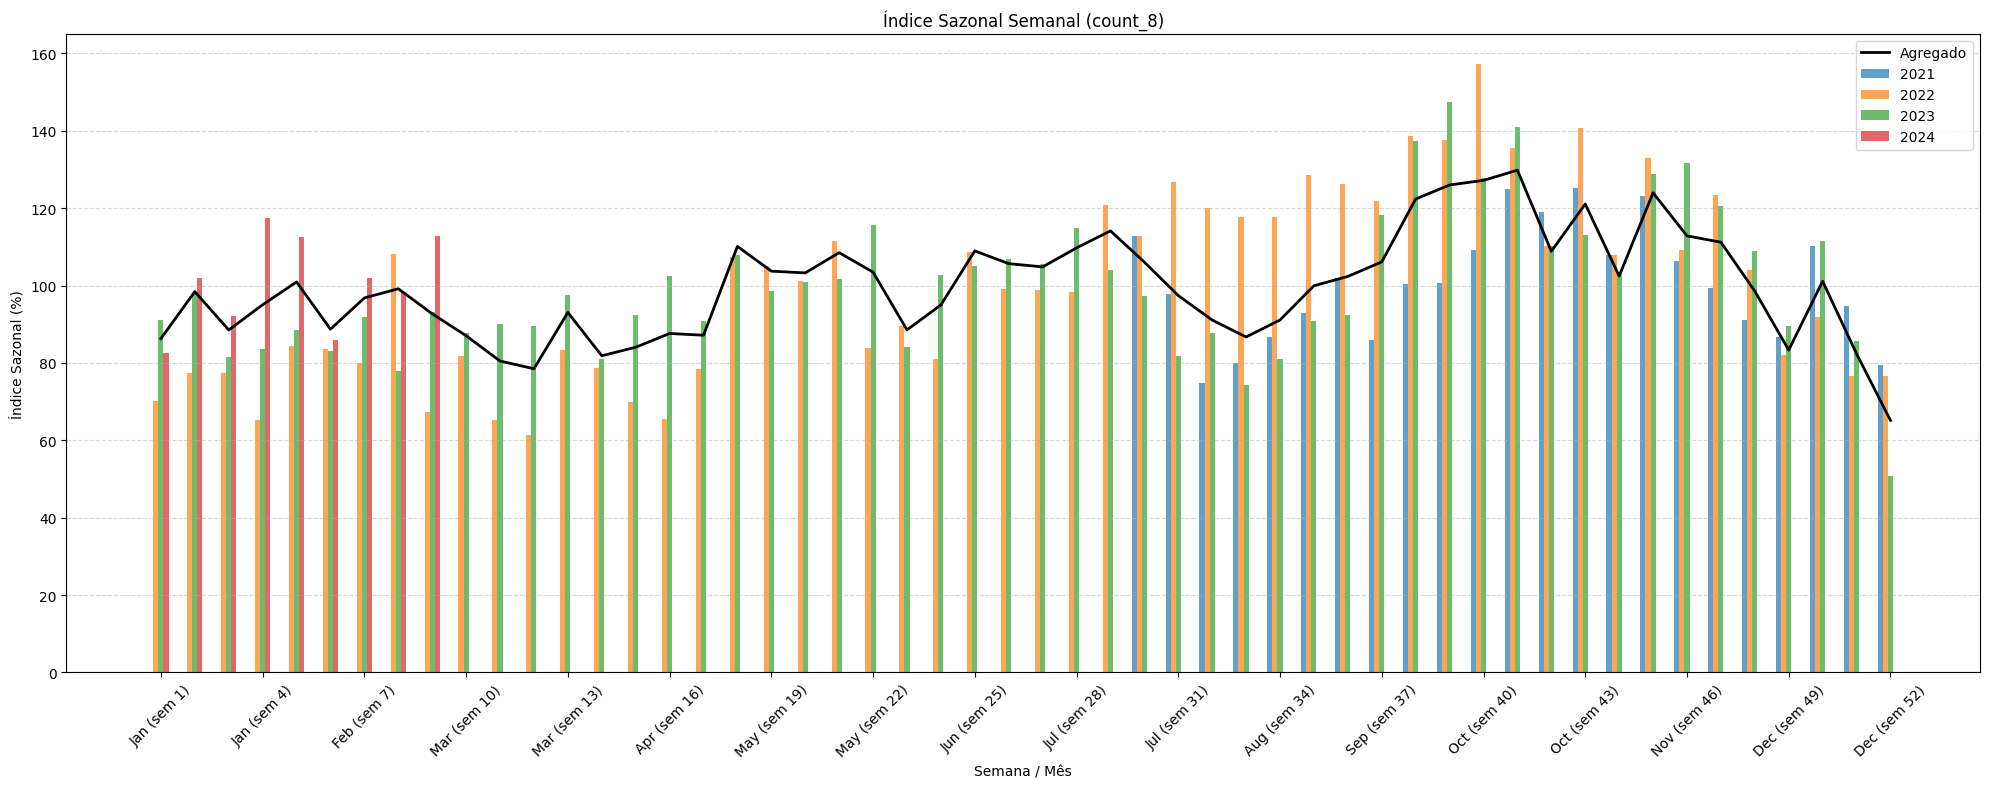

In [ ]:
# gráfico de barras 
df_pivot = df_indices.pivot(index='semana', columns='ano', values='indice_sazonal').reset_index()
df_pivot = pd.merge(df_pivot, df_agregado[['semana', 'indice_sazonal_agg']], on='semana')
df_pivot = df_pivot.sort_values('semana')

# Data fictícia para extrair mês e rótulo
df_pivot['date_dummy'] = pd.to_datetime('2021-01-01') + pd.to_timedelta((df_pivot['semana'] - 1) * 7, unit='D')
df_pivot['mes'] = df_pivot['date_dummy'].dt.month
df_pivot['nome_mes'] = df_pivot['mes'].apply(lambda x: calendar.month_abbr[x])
df_pivot['rotulo_x'] = df_pivot['nome_mes'] + ' (sem ' + df_pivot['semana'].astype(str) + ')'

plt.figure(figsize=(20, 8))
width = 0.15
anos = sorted(df_indices['ano'].unique())
positions = range(len(df_pivot))

# Barras para cada ano
for i, ano in enumerate(anos):
    if ano in df_pivot.columns:
        plt.bar(
            [p + (i - len(anos)/2)*width for p in positions],
            df_pivot[ano],
            width=width,
            label=str(ano),
            alpha=0.7
        )

# Linha agregada
plt.plot(positions, df_pivot['indice_sazonal_agg'], color='black', linewidth=2, label='Agregado')

plt.xticks(positions[::3], df_pivot['rotulo_x'][::3], rotation=45)
plt.xlabel("Semana / Mês")
plt.ylabel("Índice Sazonal (%)")
plt.title("Índice Sazonal Semanal (count_8)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

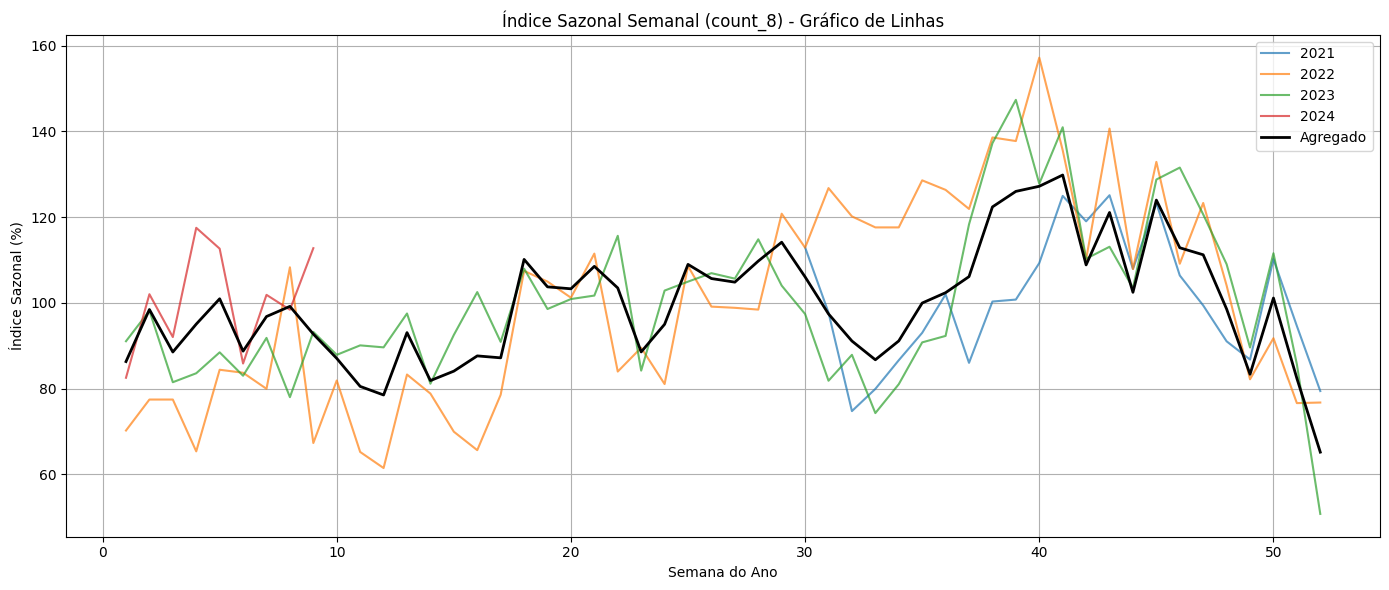

In [26]:
plt.figure(figsize=(14, 6))
for ano in anos:
    plt.plot(df_pivot['semana'], df_pivot[ano], label=str(ano), alpha=0.7)
plt.plot(df_pivot['semana'], df_pivot['indice_sazonal_agg'], color='black', linewidth=2, label='Agregado')

plt.xlabel('Semana do Ano')
plt.ylabel('Índice Sazonal (%)')
plt.title('Índice Sazonal Semanal (count_8) - Gráfico de Linhas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Seasonality indicator

In [33]:
indice_agrupado = df_indices.groupby('semana')['indice_sazonal'].mean().reset_index()
indice_agrupado.columns = ['semana', 'Agregado']
seasonality_indicators = df_indices.groupby('ano')['indice_sazonal'].agg(lambda x: 100 / x.max()).reset_index(name='seasonality_indicator')
seasonality_indicator_agg = 100 / indice_agrupado['Agregado'].max()
print(seasonality_indicators)
print(f"Seasonality Indicator agregado: {seasonality_indicator_agg:.2f}")

    ano  seasonality_indicator
0  2021               0.799345
1  2022               0.636092
2  2023               0.678616
3  2024               0.851064
Seasonality Indicator agregado: 0.75


Valore mais próximos de 1 indicam que o uso é mais uniforme ao longo do ano, sem grandes variações entre semanas. 2022 com 0.64 indica maior concentração do uso em poucas semanas, ou seja, menos uniformidade e mais sazonalidade. Uso fortemente concentradi em determinadas semanas. 

# Seasonality index 

In [42]:
df_count8 = df[['count_8']].copy()
df_count8.index = pd.to_datetime(df_count8.index)
df_count8['year'] = df_count8.index.isocalendar().year
df_count8['week'] = df_count8.index.isocalendar().week

weekly_counts = df_count8.groupby(['year', 'week'])['count_8'].sum().reset_index()
weekly_counts = weekly_counts.sort_values(by=['year', 'week']).reset_index(drop=True)

# calcular média moveis de 52 semanas (anual)
weekly_counts['ma_52'] = weekly_counts['count_8'].rolling(window=52, center=True).mean()

# calcular a razão entre o valor real e a média movel
weekly_counts['ratio'] = weekly_counts['count_8'] / weekly_counts['ma_52']

# Agrupar por nº de semanas e calcular a mediana do ratio
seasonal_medians = weekly_counts.groupby('week')['ratio'].median().reset_index()

# Normalizar
seasonal_medians['index'] = seasonal_medians['ratio'] * 52 / seasonal_medians['ratio'].sum()


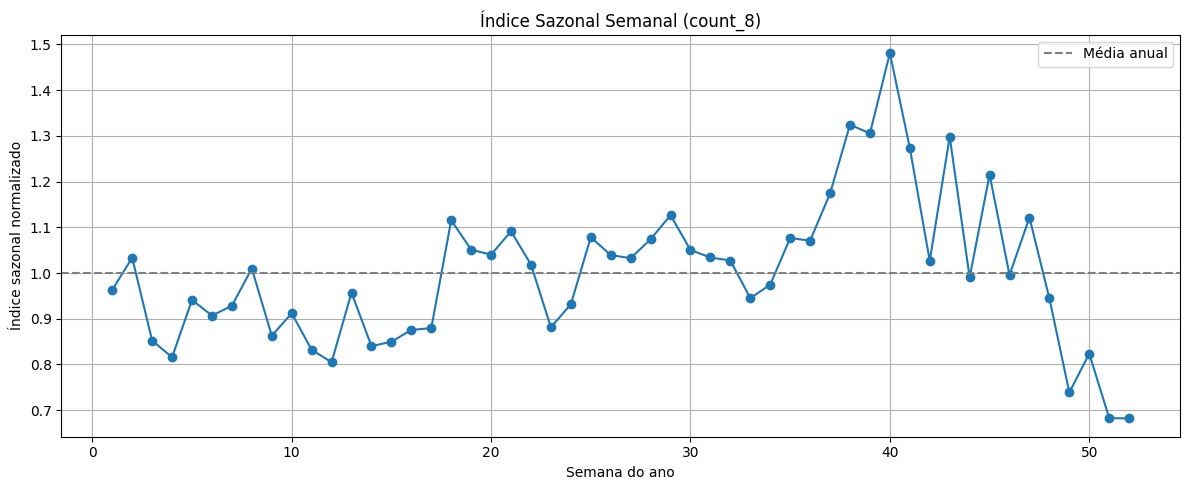

In [43]:
plt.figure(figsize=(12, 5))
plt.plot(seasonal_medians['week'], seasonal_medians['index'], marker='o')
plt.axhline(1, color='gray', linestyle='--', label='Média anual')
plt.title('Índice Sazonal Semanal (count_8)')
plt.xlabel('Semana do ano')
plt.ylabel('Índice sazonal normalizado')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Valores acima de 1 indicam mais bicicletas do que a média anual. 
Valores abaixo de 1 indicam menos biciceltas do que a média anual. 
Da semana 1 até +/- a semana 15 (Janeiro até inicio de Abril), o indice esta abaixo de 1. Periodo de baica mobilidade (provavelmente devido ao tempo). 
Da semana 16 até 30 (Abril até Julho) subiu acima de 1. 
Semanas 31 até 40 (agosto até final de Setembro), temos pico marcantes, sendo o maior na semana 40. 
Semanas 41 até 52 (Outubro a dezembro), declinio progressivo. 
Portanto, temos baixo uso no inverno. Uso médio a crescente na primavera e inicio do verão. Pico marcante no fim de verão/inicio do outono. 

### Seasonality Rate

In [44]:
# Obter a contagem semanal agregada por ano e semana
s_por_ano = df_semanal.groupby('ano')['count_8'].agg(['max', 'min']).reset_index()
s_por_ano['S'] = s_por_ano['max'] / s_por_ano['min']

# S agregado (em todas as semanas)
s_agg = df_semanal['count_8'].max() / df_semanal['count_8'].min()

print(s_por_ano[['ano', 'S']])
print(f"Seasonality Rate (agregado): {s_agg:.2f}")


    ano          S
0  2021   5.205882
1  2022  13.428571
2  2023   6.100000
3  2024   6.284891
Seasonality Rate (agregado): 17.43


Em 2021 a semana com maior contagem teve 5 vezes mais bicicletas do que a semana com menor contagem. 
Em 2022, o pico semanal foi 13 vezes maior do que o ponto mais baixo. Sazonalidade muito intensa. 
2023 e 2024 são semelhantes. 

### Relative Intensity 

In [45]:
s_por_ano['I'] = s_por_ano['max'] - s_por_ano['min']
i_agg = df_semanal['count_8'].max() - df_semanal['count_8'].min()

print(s_por_ano[['ano', 'I']])
print(f"Relative Intensity (agregado): {i_agg}")


    ano          I
0  2021  143.00000
1  2022  174.00000
2  2023  204.00000
3  2024  190.25607
Relative Intensity (agregado): 230.0


Em 2022 a diferença entre a semana com mais contagens e a com menos foi de 143 bicicletas. 

### MUS

In [46]:
# Média anual de dormidas (ou neste caso, contagens semanais)
mus_por_ano = df_semanal.groupby('ano')['count_8'].agg(['mean', 'max']).reset_index()
mus_por_ano['MUS'] = 100 * mus_por_ano['max'] / mus_por_ano['mean']

# MUS agregado
mus_agg = 100 * df_semanal['count_8'].max() / df_semanal['count_8'].mean()

print(mus_por_ano[['ano', 'MUS']])
print(f"MUS agregado: {mus_agg:.2f}")


    ano         MUS
0  2021  188.566706
1  2022  182.925005
2  2023  198.492788
3  2024  183.526167
MUS agregado: 221.03


Mede a magnitude média dos aumentos semanais consecutivos na série temporal. Quanto cresce em média o nº de bicicletas de uma semana para a seguinte quando há aumento. 
Em média em 2022 os aumentos semanais positivos foram de 182,9 bicicletas

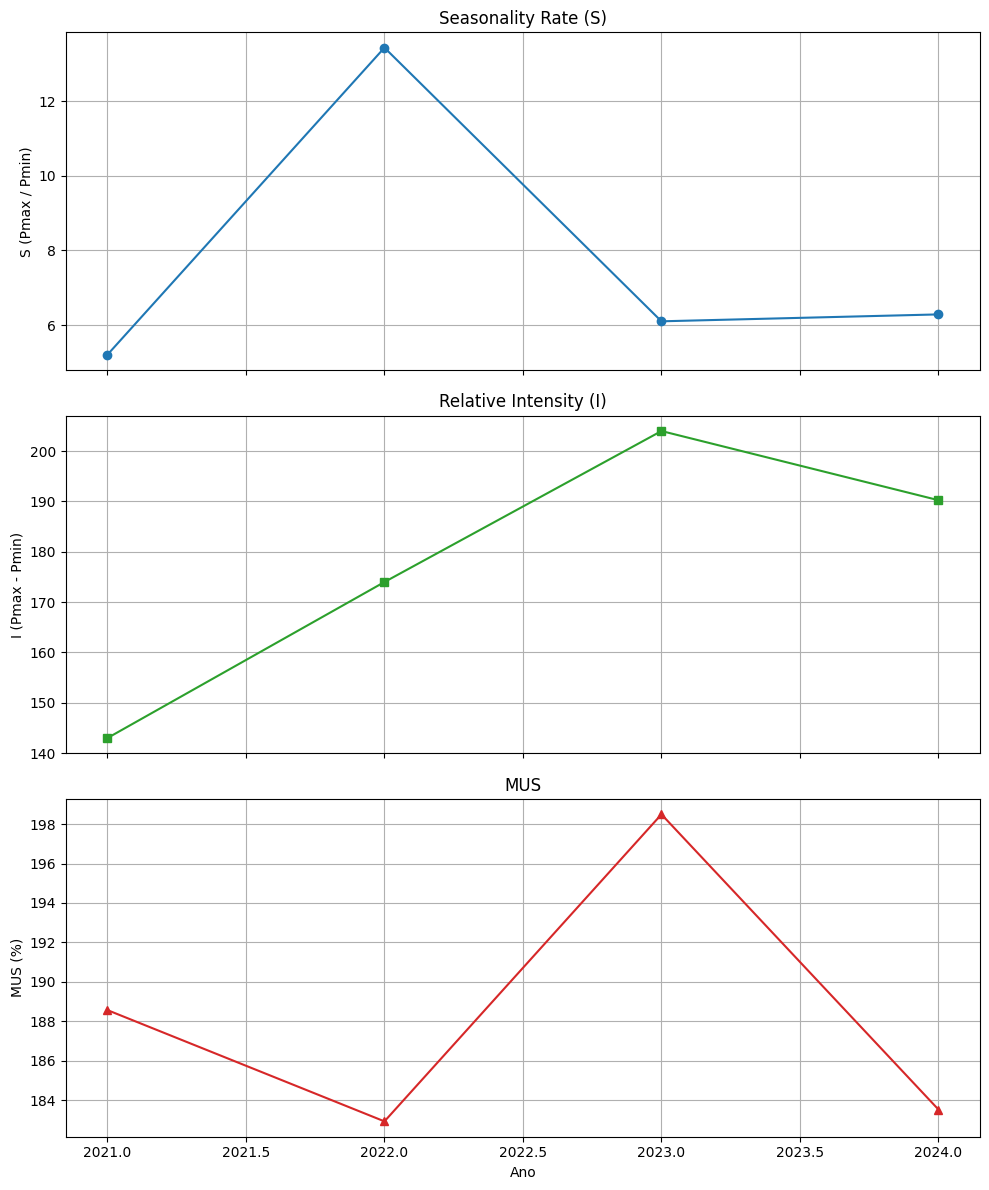

In [ ]:
# Gráfico dos três indicadores: S, I, MUS

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot S
axs[0].plot(s_por_ano['ano'], s_por_ano['S'], marker='o', color='tab:blue')
axs[0].set_title('Seasonality Rate (S)')
axs[0].set_ylabel('S (Pmax / Pmin)')
axs[0].grid(True)

# Plot I
axs[1].plot(s_por_ano['ano'], s_por_ano['I'], marker='s', color='tab:green')
axs[1].set_title('Relative Intensity (I)')
axs[1].set_ylabel('I (Pmax - Pmin)')
axs[1].grid(True)

# Plot MUS
axs[2].plot(mus_por_ano['ano'], mus_por_ano['MUS'], marker='^', color='tab:red')
axs[2].set_title('MUS')
axs[2].set_ylabel('MUS (%)')
axs[2].set_xlabel('Ano')
axs[2].grid(True)

plt.tight_layout()
plt.show()
